In [47]:
include("../code/julia/ha-trade.jl")
include("../code/julia/ha-trade-welfare.jl")

using MINPACK
using Plots
using CSV
using DataFrames

In [48]:
γ = 1.5 # curvatuve on CRRA utility function
σϵ = 0.25 # logit dispersion parameter
Ncntry = 2 # number of countries

# this setups up parameters on the household side
hh_prm = household_params(Ncntry = Ncntry, Na = 100, β = 0.92, γ = γ, ϕ = 0.5, amax = 8.0, σϵ = σϵ, ψslope = 0.2);

#ψslope controls how residual demand varies with income state...

In [49]:
# here are some simpe country parametrers
TFP = [1.0; 1.0]

τ = [0.0; 0.0]

L = [1.0; 1.0]

d_ij = 1.745

d = [1.0 d_ij; d_ij 1.0]

# this sets up the country specific paramters
cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [50]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, cntry_prm)
# this world... function is used to construct zero conditions for
# the finacial globalization case

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

# This solver works very well in general. Spencer Lyon converted old-school minpack
# routines in C into julia

print(sol)

wage = [exp.(sol.x[1]); 1.0]
R = exp.(sol.x[2])

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.992083e-01     0.000000e+00         2.705000
     2     2.253156e-02     4.054422e-05         0.306000
     3     3.170333e-03     1.074674e-06         0.154000
     4     4.916331e-05     2.946856e-08         0.107000
     5     1.685977e-07     7.182151e-12         0.133000
     6     1.002796e-10     8.588696e-17         0.133000
     7     4.424239e-13     2.833389e-23         0.102000
     8     3.289036e-15     5.500317e-28         0.104000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-2.2768317339848573e-9, 0.01258038097184609]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 3.744000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

1.012659846851913

In [51]:
Rsol = [R; R]

Y, tradeflows, A_demand, Gbudget, tradeshare, hh, dist = world_equillibrium(Rsol, wage, τ, hh_prm, cntry_prm, tol_vfi = 1e-10);


In [52]:
R

1.012659846851913

In [53]:
tradeshare

2×2 Matrix{Float64}:
 0.912448   0.0875522
 0.0875522  0.912448

In [54]:
hh[1].πprob[:,:,2]
# guys in country one, a X z, probability of buying from 2

100×10 Matrix{Float64}:
 0.0203927  0.0360656  0.0380981  …  0.069461   0.0833217  0.0675049
 0.0374807  0.0397536  0.0524594     0.0704901  0.0860155  0.0678605
 0.0517403  0.0489637  0.0661095     0.071409   0.0879135  0.06821
 0.057837   0.0523315  0.0715266     0.0722387  0.089045   0.0685533
 0.0693525  0.0560704  0.0789035     0.0730149  0.0898944  0.0688905
 0.0744127  0.0612837  0.08379    …  0.0737619  0.0906548  0.0692287
 0.0797019  0.0647962  0.087817      0.0745066  0.0913656  0.0695538
 0.0862534  0.0682007  0.0925053     0.0752162  0.0920282  0.0698665
 0.0913775  0.0715594  0.096533      0.0758752  0.0926106  0.0701749
 0.0959336  0.0749256  0.0996836     0.0765248  0.0931592  0.0704782
 0.100463   0.0778429  0.10262    …  0.0771596  0.0936835  0.0707768
 0.105026   0.0807764  0.105696      0.077774   0.094189   0.0710721
 0.108972   0.0836368  0.108843      0.0783727  0.0946961  0.0713645
 ⋮                                ⋱                        
 0.25642    0.194793 

In [55]:
cntry = 1 # this is the country I'll look at

# the next several functions are what is done to make
# the country specific, household parameter vector.

p = make_p(wage, TFP, d[cntry, :], cntry_prm.tariff[cntry, :] )
# prices from the perspective of those in that country

ψ = make_ψ(cntry, hh_prm)
# this is the quality matrix

agrid = make_agrid(hh_prm, TFP[cntry])
# this creates teh asset grid so it's alwasy a fraction of home labor income

foo_hh_prm = household_params(hh_prm, agrid = agrid, 
                TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = ψ)


hh = solve_household_problem(R, wage[cntry], p, τ[cntry], foo_hh_prm, tol = 1e-10);
# solve hh problem at those prices

dist = make_stationary_distribution(hh, foo_hh_prm);
# find stationary distribution

In [56]:
θ = make_θ(cntry, R, wage[cntry], p, τ[cntry], foo_hh_prm; points = 3, order = 1)
# makes the micro elasticities for country, cntry, 

ω = make_ω(hh, dist, L[cntry], p, foo_hh_prm)
# makes the expenditure weights

agθ = aggregate_θ(θ, ω, cntry, foo_hh_prm)
# construct the aggregate elasticity. The interesting element here is 
# agθ[cntry]

2-element Vector{Float64}:
  1.0
 -4.423364745419634

In [73]:
hh.πprob[:,:,2]

100×10 Matrix{Float64}:
 0.0203927  0.0360656  0.0380981  …  0.069461   0.0833217  0.0675049
 0.0374807  0.0397536  0.0524594     0.0704901  0.0860155  0.0678605
 0.0517403  0.0489637  0.0661095     0.071409   0.0879135  0.06821
 0.057837   0.0523315  0.0715266     0.0722387  0.089045   0.0685533
 0.0693525  0.0560704  0.0789035     0.0730149  0.0898944  0.0688905
 0.0744127  0.0612837  0.08379    …  0.0737619  0.0906548  0.0692287
 0.0797019  0.0647962  0.087817      0.0745066  0.0913656  0.0695538
 0.0862534  0.0682007  0.0925053     0.0752162  0.0920282  0.0698665
 0.0913775  0.0715594  0.096533      0.0758752  0.0926106  0.0701749
 0.0959336  0.0749256  0.0996836     0.0765248  0.0931592  0.0704782
 0.100463   0.0778429  0.10262    …  0.0771596  0.0936835  0.0707768
 0.105026   0.0807764  0.105696      0.077774   0.094189   0.0710721
 0.108972   0.0836368  0.108843      0.0783727  0.0946961  0.0713645
 ⋮                                ⋱                        
 0.25642    0.194793 

In [58]:
fooX = make_Xsection(R, wage[cntry], p, hh, dist, cntry, foo_hh_prm; Nsims = 100000)

hhXsection([0.28302093200985556, 0.28302093200985556, 0.44695916901634364, 0.44695916901634364, 0.44522538299486925, 0.7031196095469024, 0.44522538299486925, 0.7031196095469024, 0.44695916901634364, 0.44522538299486925  …  0.7003921591779129, 1.1060902641675332, 0.7003921591779129, 0.7003921591779129, 0.7003921591779129, 0.7003921591779129, 1.1017996623151916, 1.740010740526207, 1.1017996623151916, 1.740010740526207], [3.0202020202020203, 2.3333333333333335, 1.6464646464646464, 1.1313131313131313, 0.8737373737373737, 0.4444444444444444, 0.35858585858585856, 0.10101010101010101, 0.015151515151515152, -0.0707070707070707  …  0.015151515151515152, -0.24242424242424243, -0.0707070707070707, -0.24242424242424243, -0.41414141414141414, -0.5, -0.5, -0.5, -0.0707070707070707, -0.41414141414141414], [3.341458247249472, 2.6458939079976527, 2.1142678057523216, 1.5925945513134574, 1.3300241380725508, 1.153190652592197, 0.8083508836336866, 0.8054084829662876, 0.46230250002925144, 0.3736231716012996

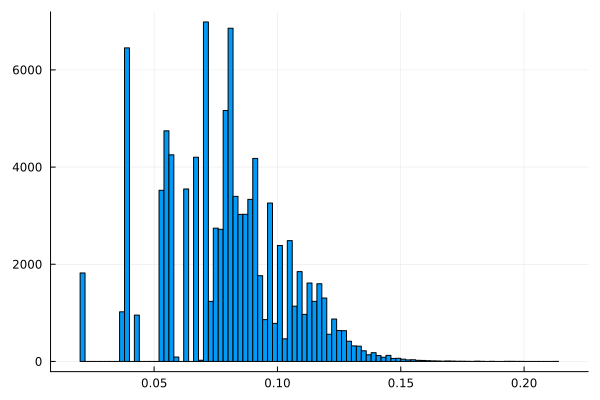

In [59]:
histogram((1.0 .-fooX.homeshare), label = false)

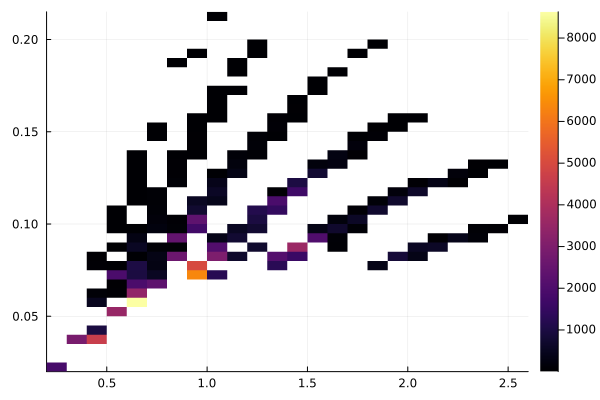

In [60]:
histogram2d(fooX.pc, (1.0 .-fooX.homeshare))

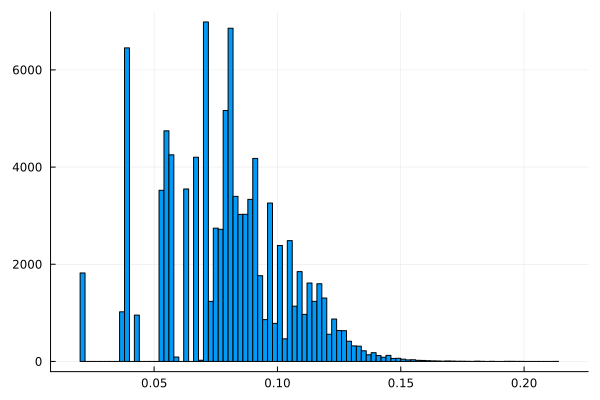

In [61]:
histogram((1.0 .-fooX.homeshare), label = false)

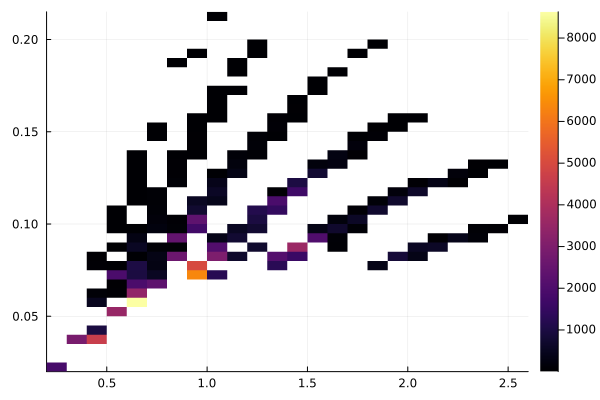

In [62]:
histogram2d(fooX.pc, (1.0 .-fooX.homeshare))

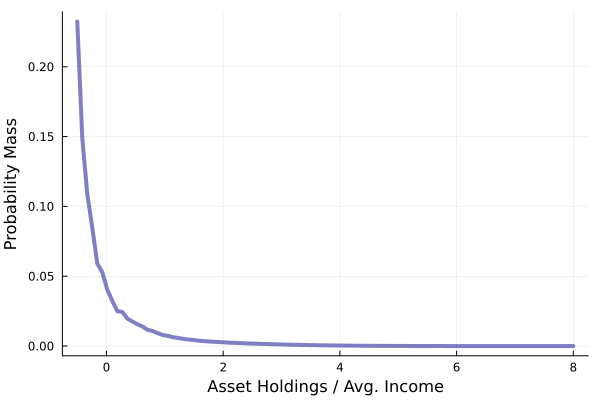

In [63]:
adist = get_distribution(dist.state_index, dist.λ);

plot(hh_prm.agrid , adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", 
    xlabel = "Asset Holdings / Avg. Income", label = false)

In [64]:
Δd = 0.10

d = [1.0 d_ij * (1 - Δd)  ; d_ij * (1 - Δd)  1.0]

# this sets up the country specific paramters
Δd_cntry_prm = country_params(Ncntry = Ncntry, L = L, d = d, TFP = TFP);

In [65]:
f(x) = world_equillibrium_FG(exp.(x), hh_prm, Δd_cntry_prm)

function f!(fvec, x)

    fvec .= f(x)

end


xguess = [1.0; 1.02]

n = length(xguess)
diag_adjust = n - 1

sol = fsolve(f!, log.(xguess), show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-10,
       )

print(sol)

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     2.076628e-01     0.000000e+00         0.122000
     2     2.401431e-02     4.322653e-05         0.341000
     3     3.369768e-03     9.742138e-07         0.127000
     4     6.065843e-05     2.573251e-08         0.113000
     5     1.294972e-07     8.681806e-12         0.138000
     6     3.226280e-10     4.129300e-17         0.130000
     7     1.866389e-12     2.335057e-22         0.101000
     8     1.658396e-15     7.991134e-27         0.133000
Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [0.0, 0.01980262729617973]
 * Zero: [-1.5653828386609878e-9, 0.012281498076045965]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.205000 seconds
 * Function Calls: 8
 * Jacobian Calls (df/dx): 1

In [66]:
Δwage = [exp.(sol.x[1]); 1.0]
ΔR = exp.(sol.x[2])

ΔRsol = [ΔR; ΔR]


ΔY, Δtradeflows, ΔA_demand, ΔGbudget, Δtradeshare, Δhh, Δdist = world_equillibrium(ΔRsol, Δwage, τ, hh_prm, 
                                                Δd_cntry_prm, tol_vfi = 1e-10);

In [67]:
ΔR

1.0123572253708704

In [68]:
Δtradeshare

2×2 Matrix{Float64}:
 0.867717  0.132283
 0.132283  0.867717

In [69]:
# cntry = 1

# ψ = make_ψ(cntry, hh_prm)
# # this is the quality matrix

# agrid = make_agrid(hh_prm, TFP[cntry])
# # this creates teh asset grid so it's alwasy a fraction of home labor income

# foo_hh_prm = household_params(hh_prm, agrid = agrid, 
#                 TFP = TFP[cntry], L = L[cntry], σϵ = σϵ*(TFP[cntry]^(1.0 - γ)), ψ = ψ)


# λeqv = lucas_eq_variation(hh, Δhh[cntry], dist.state_index, foo_hh_prm)

λeqv

In [70]:
ΔR - R

-0.0003026214810426531